# Demonstration of preprocessing data and training GANs in REKINDLE

In this notebook we show you how to preprecess the training data (kinetic parameter sets generated by ORACLE) and then train the GANs for efficient generation. For this demonstration we provide a toy dataset consisting of 1000 kinetic parameter sets, stored in the folder /models/toy_data/toy_data.h5, the respective eigenvalues and a pickle file containing the names of the kinetic parameters. We dont expect that the learning will be complete with the toy dataset. The complete dataset (consisting of 80000 kinetic parameter sets for each physiology presented in the manuscript) can be found here - https://zenodo.org/record/5803120 (specifically in the models.zip / subfolder 4),

In [1]:

## Imports
import os, sys
import time
import yaml
import h5py
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from cGANtools.GAN import CGAN
import helper as hp


GPU is available


## Preprocessing data

In [2]:
start = time.time()
print('\nSTARTING PREPROCESSING')

# pre-processing parameters

number_of_models = 1000  # No of kinetic models
parameter_set_dim = 411  # No of kinetic parameters in model

# fetch training set parameters
path_parameters = 'models/toy_data/toy_data.h5'

# fetch training set eigenvalues
path_stability = 'models/toy_data/toy_data.csv'
if not path_stability.endswith('.csv'):
    raise ValueError('Your data must be a .csv file')

# fetch parameter names
with open('models/toy_data/parameter_names.pkl', 'rb') as f:
    parameter_names = pickle.load(f)


# get the data and processed
f = h5py.File(path_parameters, 'r')
stabilities = pd.read_csv(path_stability).iloc[:, 1].values


all_data = np.empty([number_of_models, parameter_set_dim])
all_stabilities = np.empty([number_of_models])

J_partition = -9  #<--- Create class partition based on this eigenvalue
count0, count1 = 0, 0

for i in range(0, number_of_models):

    if i % 100 == 0:
        print(f'current set processed: {i}')
    this_param_set = f'parameter_set_{i}'
    param_values = np.array(f.get(this_param_set))

    mreal = stabilities[i]

    if mreal >= J_partition:
        stability = 1
        count0 += 1
    elif mreal < J_partition:
        stability = -1
        count1 += 1

    all_data[i] = param_values
    all_stabilities[i] = stability

all_data = np.array(all_data)
all_stabilities = np.array(all_stabilities)

n_param = all_data.shape[0]
print(f'% relevant models: {count1 / n_param}')

# keep only km

idx_to_keep = [i for i, x in enumerate(parameter_names) if 'km_' in x]
all_km = all_data[:, idx_to_keep]
all_km_names = [x for i, x in enumerate(parameter_names) if 'km_' in x]

print(f'Shape of all data: {all_km.shape}')

# take the log
log_all_data = np.log(all_km)  #Log transform all parameters

# train-val split
ratio = float(0.9)  # Partition of training and test data
n_data = log_all_data.shape[0]
limit = int(ratio * n_data)
all_idx = np.arange(n_data)
np.random.shuffle(all_idx)

idx_tr = all_idx[:limit]
idx_val = all_idx[limit:]

tr_data = log_all_data[idx_tr]
val_data = log_all_data[idx_val]

tr_stabi = all_stabilities[idx_tr]
val_stabi = all_stabilities[idx_val]

print(f'N data for training: {tr_data.shape[0]}')
print(f'N data for validation: {val_data.shape[0]}')

# save everything
exp_id = 'toy'
savepath = f'gan_input/{exp_id}'
os.makedirs(savepath, exist_ok=True)
np.save(f'{savepath}/all_km_{exp_id}.npy', all_km)
np.save(f'{savepath}/all_targets_{exp_id}.npy', all_stabilities)
np.save(f'{savepath}/X_train_{exp_id}.npy', tr_data)
np.save(f'{savepath}/X_val_{exp_id}.npy', val_data)

np.save(f'{savepath}/y_train_{exp_id}.npy', tr_stabi)
np.save(f'{savepath}/y_val_{exp_id}.npy', val_stabi)

with open(f'{savepath}/parameter_names_{exp_id}.pkl', 'wb') as f:
    pickle.dump(parameter_names, f)
with open(f'{savepath}/parameter_names_km_{exp_id}.pkl', 'wb') as f:
    pickle.dump(all_km_names, f)

end = time.time()
print(f'PROCESSING DONE in {end - start:.05} seconds')



STARTING PREPROCESSING
current set processed: 0
current set processed: 100
current set processed: 200
current set processed: 300
current set processed: 400
current set processed: 500
current set processed: 600
current set processed: 700
current set processed: 800
current set processed: 900
% relevant models: 0.592
Shape of all data: (1000, 259)
N data for training: 900
N data for validation: 100
PROCESSING DONE in 0.069597 seconds


## Training CGANs

In [3]:
# Training hyperparameters

latent_dim = 127      # Length of noise vector
epochs = 100           # Total number of epochs
n_sample = 100        # No of parameter sets to generate at every sampling epoch
repeats = 1           # number of training repeats
batchsize = 50      # Batchsize
sample_interval = 10  # Frequency of testing generator

exp_id = 'toy'       #<-- Choose 1 of 4 physiologies (fdp1-fdp4) or 'toy'
path_generator = None #<---if doing transfer learning put path to trained generator here else leave None
                      #    if loading model using load_model gives an error upgrade tensorflow to v2.3.0
                      #    > pip install tensorflow==2.3.0

print('\nSTARTING CGAN TRAINING')

# load the data for appropriate experiment
datapath = f'gan_input/{exp_id}/'
X_train = np.load(f'{datapath}X_train_{exp_id}.npy')
y_train = np.load(f'{datapath}y_train_{exp_id}.npy')

# Specify output folders
savepath = f'gan_output/{exp_id}/'

for j in range(0, repeats):

    print(f'Current exp: {exp_id}: Samples used: {np.shape(X_train)[0]}, repeat {j}')
    # set save directory
    this_savepath = f'{savepath}repeat_{j}/'
    os.makedirs(this_savepath, exist_ok=True)

    cgan = CGAN(X_train, y_train, latent_dim, batchsize, path_generator, savepath= this_savepath)
    d_loss, g_loss, acc = cgan.train(epochs, sample_interval, n_sample)

    # store training summary

    this_train_savepath = f'{this_savepath}training_summary/'
    os.makedirs(this_train_savepath, exist_ok=True)

    with open(f'{this_train_savepath}d_loss.pkl', 'wb') as f:
        pickle.dump(d_loss, f)
    with open(f'{this_train_savepath}g_loss.pkl', 'wb') as f:
        pickle.dump(g_loss, f)
    with open(f'{this_train_savepath}acc.pkl', 'wb') as f:
        pickle.dump(acc, f)


STARTING CGAN TRAINING
Current exp: toy: Samples used: 900, repeat 0
Total trainable parameters: 1012956


/nix/store/zdqwf0rfm4mdc3l4x0j2ncl8hb0pfz0r-devenv-profile/lib/python3.12/site-packages/torch/nn/modules/linear.py:125: UserWarning: Attempting to use hipBLASLt on an unsupported architecture! Overriding blas backend to hipblas (Triggered internally at /build/pytorch/aten/src/ATen/Context.cpp:296.)
  return F.linear(input, self.weight, self.bias)


Epoch 0, D loss: 41.12450408935547, G loss: 7.170815467834473
Epoch 1, D loss: 2.480983257293701, G loss: 0.570456862449646
Epoch 2, D loss: 3.255064010620117, G loss: 0.6057430505752563
Epoch 3, D loss: 3.289097785949707, G loss: 0.5998993515968323
Epoch 4, D loss: 3.406524896621704, G loss: 0.6306580901145935
Epoch 5, D loss: 3.1254189014434814, G loss: 0.5982072353363037
Epoch 6, D loss: 2.5382697582244873, G loss: 0.5803879499435425
Epoch 7, D loss: 1.818280577659607, G loss: 0.6301371455192566
Epoch 8, D loss: 2.064796209335327, G loss: 0.7523387670516968
Epoch 9, D loss: 1.8242217302322388, G loss: 0.7493153214454651
Epoch 10, D loss: 1.808390498161316, G loss: 0.7711074948310852
Epoch 11, D loss: 1.7974181175231934, G loss: 0.7639524936676025
Epoch 12, D loss: 1.8091795444488525, G loss: 0.7806296348571777
Epoch 13, D loss: 2.383598804473877, G loss: 0.851942777633667
Epoch 14, D loss: 3.306490898132324, G loss: 0.5269577503204346
Epoch 15, D loss: 3.1806459426879883, G loss: 0.

## Plot criterion losses

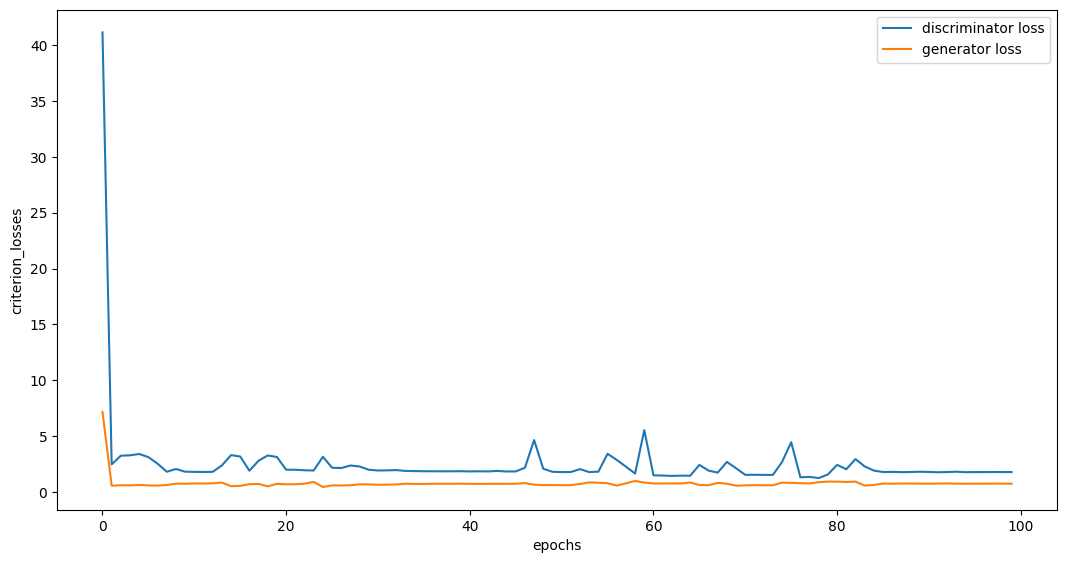

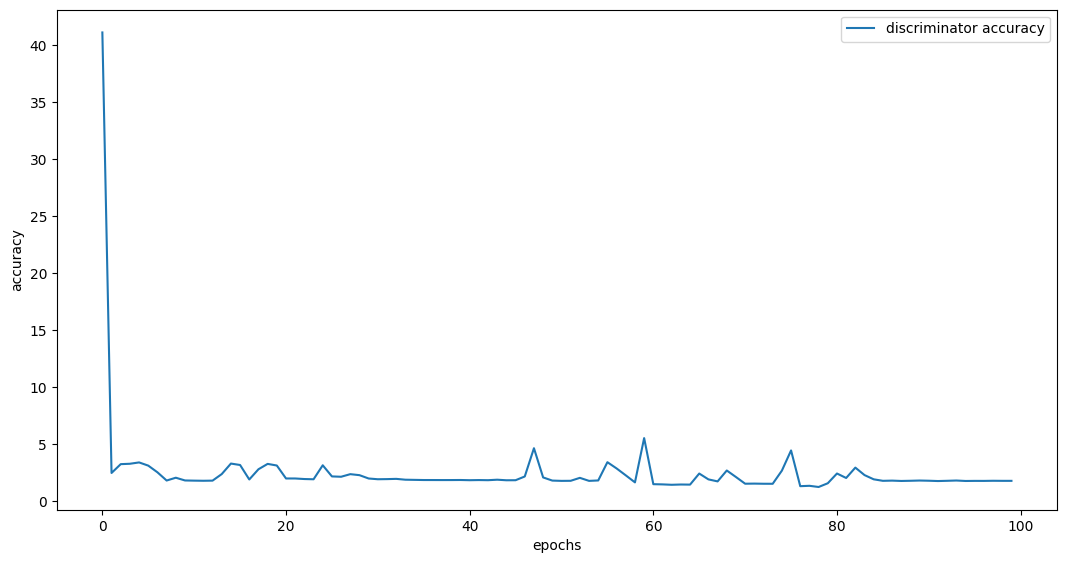

In [4]:
# plot metrics
x_plot = np.arange(0, epochs, 1)

fig = plt.figure(figsize = (10,5))
ax1 = fig.add_axes([0.2, 0.2, 1, 1])

ax1.plot(x_plot, d_loss, label = 'discriminator loss')
ax1.plot(x_plot, g_loss, label= 'generator loss')
ax1.set( ylabel = 'criterion_losses', xlabel = 'epochs')
ax1.legend()
plt.savefig(f'{this_train_savepath}loss.svg', dpi=300,
            transparent=False, bbox_inches='tight')

fig = plt.figure(figsize= (10,5))
ax2 = fig.add_axes([0.2, 0.2, 1, 1])

ax2.plot(x_plot, d_loss, label='discriminator accuracy')
ax2.set(ylabel='accuracy', xlabel='epochs')
ax2.legend()
plt.savefig(f'{this_train_savepath}d_accuracy.svg', dpi=300,
            transparent=False, bbox_inches='tight')

## Plot KL divergence

In [5]:
#Fetch relevant training data

training_data = np.load('gan_input/toy/X_train_toy.npy')
training_labels = np.load('gan_input/toy/y_train_toy.npy')

relevant_idx = np.where(training_labels==-1)[0]
relevant_training_data = training_data[relevant_idx,:]

training_mean = np.mean(relevant_training_data, axis = 0)

KL = []


#calculate KL divergence
for j in range(0, epochs, sample_interval):
    
    this_generated_set = np.load(f'gan_output/toy/repeat_0/{j}_r.npy')
    this_set_mean = np.mean(this_generated_set, axis = 0)
                                 
    p, q = hp.get_distributions([training_mean, this_set_mean])
    KL.append(hp.KL_div(p,q))                             

AttributeError: module 'helper' has no attribute 'get_distributions'

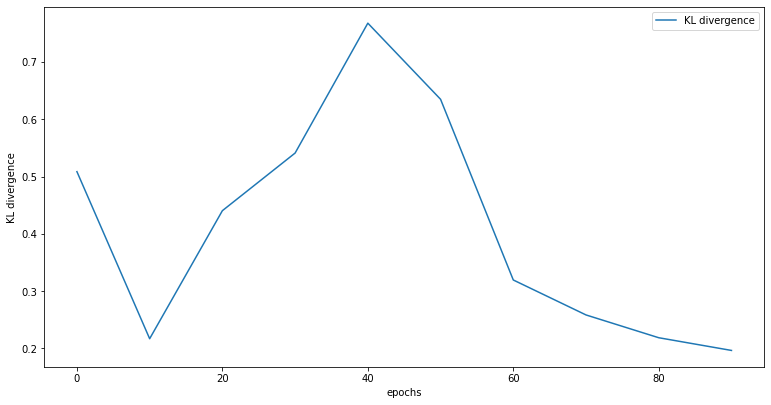

In [ ]:
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_axes([0.2, 0.2, 1, 1])

x_plot = np.arange(0, epochs, sample_interval)
ax1.plot(x_plot, KL, label = 'KL divergence')
ax1.set( ylabel = 'KL divergence', xlabel = 'epochs')
ax1.legend()
plt.savefig(f'{this_train_savepath}KL_divergence.svg', dpi=300,
            transparent=False, bbox_inches='tight')